In [56]:
import pandas as pd
import re
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from collections import Counter
from PIL import Image

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim import corpora
from imageio import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [20]:
# Load the data
ds_corpus_df = pd.read_csv('../corpus/deepseek_news_corpus.csv')

In [21]:
# display the data
ds_corpus_df

,URL,Title,Date,Content,Status_Code,Validation
0,https://www.techtarget.com/whatis/feature/Deep...,DeepSeek explained: Everything you need to know,2025-01-20,"In the world of AI, there has been a prevailin...",200,1
1,https://venturebeat.com/ai/open-source-deepsee...,Open-source DeepSeek-R1 uses pure reinforcemen...,2025-01-20,Join our daily and weekly newsletters for the ...,200,1
2,https://siliconangle.com/2025/01/20/deepseek-o...,DeepSeek open-sources its R1 reasoning model s...,2025-01-20,\nUPDATED 17:12 EST / JANUARY 20 2025\n\n\n\n\...,200,1
3,https://medium.com/data-science-in-your-pocket...,DeepSeek-R1 vs DeepSeek-R1-Zero. DeepSeek’s ne...,2025-01-20,Sign up\nSign in\nSign up\nSign in\nMehul Gupt...,200,1
4,https://analyticsindiamag.com/ai-news-updates/...,DeepSeek Crushes OpenAI o1 with an MIT-License...,2025-01-20,"DeepSeek, a Chinese AI research lab backed by ...",200,1
...,...,...,...,...,...,...
832,https://www.techloy.com/gemini-2-0-flash-is-go...,Gemini 2.0 Flash is Google's latest response t...,2025-02-07,\n\n\nSuccess! Now Check Your Email\n\nTo comp...,200,1
833,https://newscentral.africa/us-lawmakers-seek-d...,US Lawmakers Seek DeepSeek Ban on Government D...,2025-02-07,A new bill to be introduced in the U.S. Congre...,200,1
834,https://ipdefenseforum.com/2025/02/prcs-ai-ass...,"PRC’s AI assistant, DeepSeek, censors informat...",2025-02-07,Voice of America\nUsers of the People’s Republ...,200,1
835,https://www.androidheadlines.com/2025/02/deeps...,DeepSeek and other Chinese AIs might be banned...,2025-02-07,Sign Up! \n\nenvelope_alt\n\n\n\nGet the lates...,200,1


## Pretraitement

In [22]:
# download and load the spacy model
nlp = spacy.load("en_core_web_md")


In [41]:
# we use SpaCy to preprocess the text, not NLTK

# define a function to preprocess text
def preprocess_text(text,sw_list):
    # set to lowercase
    text = text.lower()
    # remove html tags and attributes
    text = re.sub(r'<[^>]+>', '', text) 
    # remove urls
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    
    # tokenize
    doc = nlp(text)

    #  we use lemmitization instead of stemming, as it produces more readable results
    tokens = [token.lemma_ if token.lemma_ != "datum" else "data" for token in doc if token.is_alpha and not token.is_stop and token.lemma_ not in sw_list]


    
    return ' '.join(tokens)

third_part_sw_f = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
third_part_sw = set(third_part_sw_f.decode().splitlines()) 


# FINALLY, apply the preprocessing function to the content column
ds_corpus_df['preprocessed_content'] = ds_corpus_df['Content'].apply(preprocess_text(sw_list=third_part_sw))



In [42]:
ds_corpus_df

,URL,Title,Date,Content,Status_Code,Validation,preprocessed_content,top_keywords
0,https://www.techtarget.com/whatis/feature/Deep...,DeepSeek explained: Everything you need to know,2025-01-20,"In the world of AI, there has been a prevailin...",200,1,ai prevail notion develop leading edge large l...,"[attack, model, ai, jan, deepseek]"
1,https://venturebeat.com/ai/open-source-deepsee...,Open-source DeepSeek-R1 uses pure reinforcemen...,2025-01-20,Join our daily and weekly newsletters for the ...,200,1,join daily weekly newsletter late update exclu...,"[performance, model, deepseek, reasoning, rl]"
2,https://siliconangle.com/2025/01/20/deepseek-o...,DeepSeek open-sources its R1 reasoning model s...,2025-01-20,\nUPDATED 17:12 EST / JANUARY 20 2025\n\n\n\n\...,200,1,update january maria deutscher deepseek today ...,"[moe, model, ago, llm, zero]"
3,https://medium.com/data-science-in-your-pocket...,DeepSeek-R1 vs DeepSeek-R1-Zero. DeepSeek’s ne...,2025-01-20,Sign up\nSign in\nSign up\nSign in\nMehul Gupt...,200,1,sign sign sign sign mehul gupta follow data sc...,"[deepseek, sign, learn, difference, zero]"
4,https://analyticsindiamag.com/ai-news-updates/...,DeepSeek Crushes OpenAI o1 with an MIT-License...,2025-01-20,"DeepSeek, a Chinese AI research lab backed by ...",200,1,deepseek chinese ai lab high flyer capital man...,"[reasoning, aim, india, model, deepseek]"
...,...,...,...,...,...,...,...,...
832,https://www.techloy.com/gemini-2-0-flash-is-go...,Gemini 2.0 Flash is Google's latest response t...,2025-02-07,\n\n\nSuccess! Now Check Your Email\n\nTo comp...,200,1,success check email complete subscribe click c...,"[check, model, ai, google, gemini]"
833,https://newscentral.africa/us-lawmakers-seek-d...,US Lawmakers Seek DeepSeek Ban on Government D...,2025-02-07,A new bill to be introduced in the U.S. Congre...,200,1,introduce congress thursday seek ban deepseek ...,"[chatbot, ban, lawmaker, device, government]"
834,https://ipdefenseforum.com/2025/02/prcs-ai-ass...,"PRC’s AI assistant, DeepSeek, censors informat...",2025-02-07,Voice of America\nUsers of the People’s Republ...,200,1,voice america user people republic china prc a...,"[respond, question, taiwan, square, china]"
835,https://www.androidheadlines.com/2025/02/deeps...,DeepSeek and other Chinese AIs might be banned...,2025-02-07,Sign Up! \n\nenvelope_alt\n\n\n\nGet the lates...,200,1,sign late android news inbox day sign receive ...,"[sign, government, platform, ban, news]"


In [43]:
ds_corpus_df.to_csv('../corpus/deepseek_news_corpus_preprocessed.csv', index=False)

## Analyse statistiques

In [44]:
# Plot the frequency distribution of words for the entire corpus


In [45]:
# # preprocessed_list = ds_corpus_df['preprocessed_content'].tolist()
# # preprocessed_text = ' '.join(preprocessed_list)

# # get all words in a list
# all_words = ' '.join(ds_corpus_df['preprocessed_content']).split()
# word_counts = Counter(all_words)
# most_common_words = word_counts.most_common(40)  # top 0 most common words
# word_counts

In [142]:
# Global Frequency distribution of words in the corpus
def plot_corpus_frequency(df):
    all_words = ' '.join(df['preprocessed_content']).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(40)  # top 0 most common words

    words, counts = zip(*most_common_words) # unzip the list of tuples into two lists
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title("Top 40 frequent words in our corpus", fontsize=15)
    plt.xlabel("frequency", fontsize=12)
    plt.ylabel("words", fontsize=12)
    plt.tight_layout()
    plt.show()
    return

/var/folders/sl/dmcfd6sn2xz848jw02554ty40000gn/T/ipykernel_42993/149748996.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


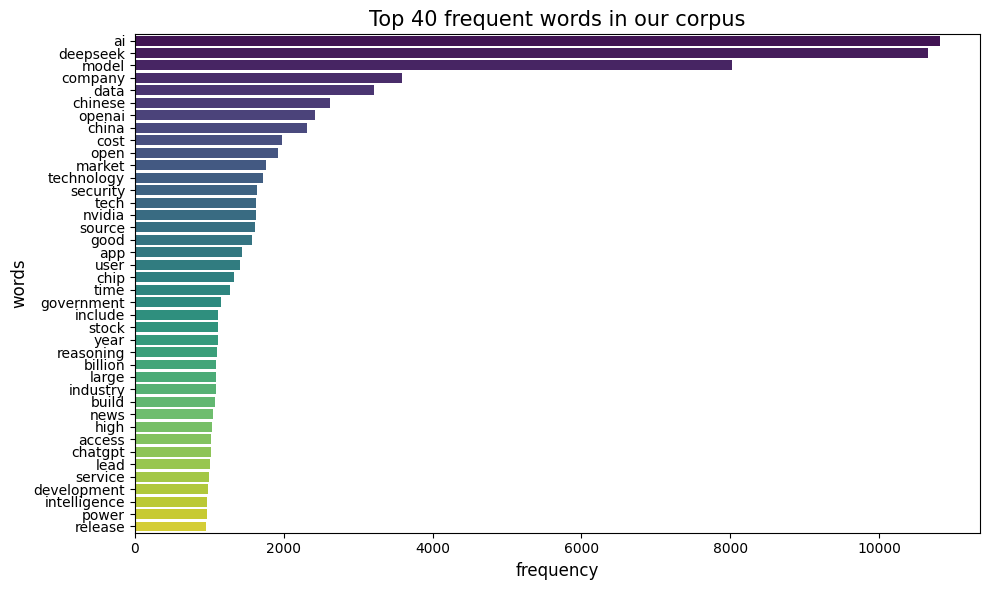

In [143]:
plot_corpus_frequency(ds_corpus_df)


In [ ]:
print(ds_corpus_df['preprocessed_content'].apply(type).value_counts())


In [144]:
ds_corpus_df

,URL,Title,Date,Content,Status_Code,Validation,preprocessed_content,top_keywords
0,https://www.techtarget.com/whatis/feature/Deep...,DeepSeek explained: Everything you need to know,2025-01-20,"In the world of AI, there has been a prevailin...",200,1,ai prevail notion develop leading edge large l...,"[attack, model, ai, jan, deepseek]"
1,https://venturebeat.com/ai/open-source-deepsee...,Open-source DeepSeek-R1 uses pure reinforcemen...,2025-01-20,Join our daily and weekly newsletters for the ...,200,1,join daily weekly newsletter late update exclu...,"[score, performance, model, deepseek, reasoning]"
2,https://siliconangle.com/2025/01/20/deepseek-o...,DeepSeek open-sources its R1 reasoning model s...,2025-01-20,\nUPDATED 17:12 EST / JANUARY 20 2025\n\n\n\n\...,200,1,update january maria deutscher deepseek today ...,"[hour, moe, model, ago, llm]"
3,https://medium.com/data-science-in-your-pocket...,DeepSeek-R1 vs DeepSeek-R1-Zero. DeepSeek’s ne...,2025-01-20,Sign up\nSign in\nSign up\nSign in\nMehul Gupt...,200,1,sign sign sign sign mehul gupta follow data sc...,"[blog, deepseek, sign, learn, difference]"
4,https://analyticsindiamag.com/ai-news-updates/...,DeepSeek Crushes OpenAI o1 with an MIT-License...,2025-01-20,"DeepSeek, a Chinese AI research lab backed by ...",200,1,deepseek chinese ai lab high flyer capital man...,"[reasoning, aim, india, model, deepseek]"
...,...,...,...,...,...,...,...,...
832,https://www.techloy.com/gemini-2-0-flash-is-go...,Gemini 2.0 Flash is Google's latest response t...,2025-02-07,\n\n\nSuccess! Now Check Your Email\n\nTo comp...,200,1,success check email complete subscribe click c...,"[check, model, ai, google, gemini]"
833,https://newscentral.africa/us-lawmakers-seek-d...,US Lawmakers Seek DeepSeek Ban on Government D...,2025-02-07,A new bill to be introduced in the U.S. Congre...,200,1,introduce congress thursday seek ban deepseek ...,"[chatbot, ban, lawmaker, device, government]"
834,https://ipdefenseforum.com/2025/02/prcs-ai-ass...,"PRC’s AI assistant, DeepSeek, censors informat...",2025-02-07,Voice of America\nUsers of the People’s Republ...,200,1,voice america user people republic china prc a...,"[respond, question, taiwan, square, china]"
835,https://www.androidheadlines.com/2025/02/deeps...,DeepSeek and other Chinese AIs might be banned...,2025-02-07,Sign Up! \n\nenvelope_alt\n\n\n\nGet the lates...,200,1,sign late android news inbox day sign receive ...,"[government, platform, ban, news, android]"


/var/folders/sl/dmcfd6sn2xz848jw02554ty40000gn/T/ipykernel_42993/3759206815.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


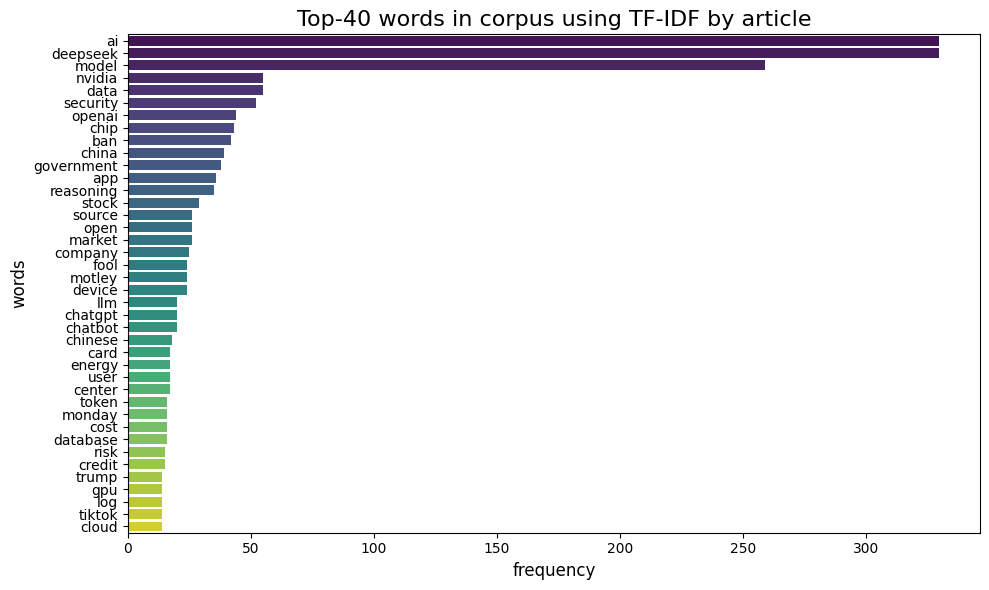

In [145]:
# or we can use TF-IDF applied to every article to get the most important words in the corpus

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english') 
X = vectorizer.fit_transform(ds_corpus_df['preprocessed_content'])

# get the feature names
feature_names = vectorizer.get_feature_names_out()

# get the top 5 keywords for each article
tfidf_scores = X.toarray()
top_keywords_per_article = []
for i, scores in enumerate(tfidf_scores):
    top_keywords = [feature_names[j] for j in scores.argsort()[-5:]] 
    top_keywords_per_article.append(top_keywords)

# store the top keywords in the dataframe for ev
ds_corpus_df['top_keywords_tfidf'] = top_keywords_per_article

# add the top keywords from every article according to TF-IDF
all_keywords = [keyword for keywords in top_keywords_per_article for keyword in keywords]
keyword_counts = Counter(all_keywords)

# visualize the top 40 keywords, these 40 words are more distinctive (contains some words that are not shown in the previous plot using  the general frequency distribution)
top_40_keywords = keyword_counts.most_common(40)
words, counts = zip(*top_40_keywords)


# plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top-40 words in corpus using TF-IDF by article", fontsize=16)
plt.xlabel("frequency", fontsize=12)
plt.ylabel("words", fontsize=12)
plt.tight_layout()
plt.show()


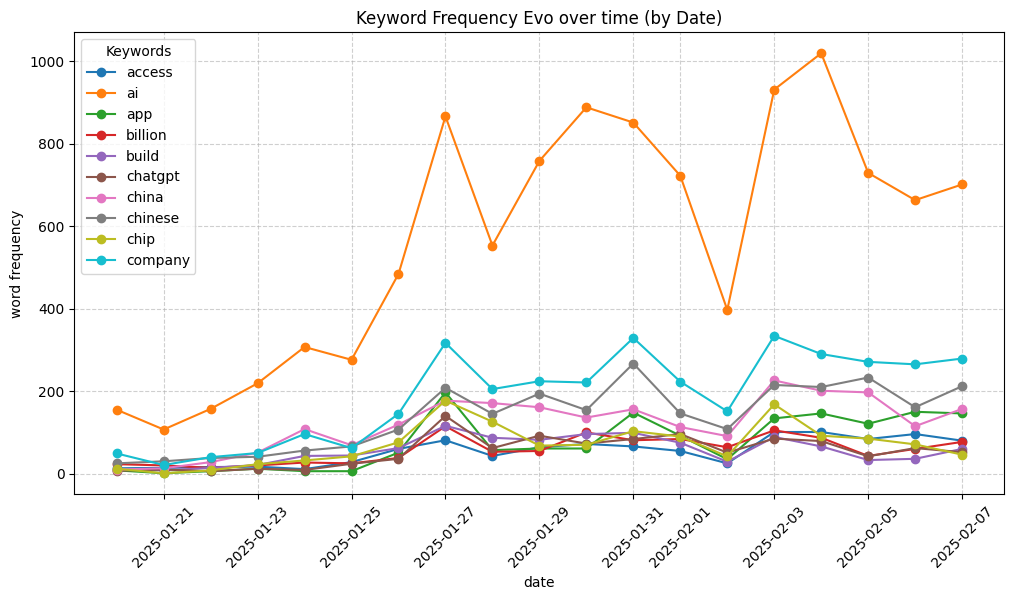

In [146]:
# we also want to see the evolution of the top keywords over time
# however,  there seems no tendency as the dominant words are not changing over time, always those words with high frequency in the corpus


start_date = "2025-01-20"  # corresponding to the first date in the dataset
end_date = "2025-02-07"    # == last date in the dataset

# make sure the date column is in datetime format
ds_corpus_df['Date'] = pd.to_datetime(ds_corpus_df['Date'])

# filter by date
filtered_df = ds_corpus_df[(ds_corpus_df['Date'] >= start_date) & (ds_corpus_df['Date'] <= end_date)]

# get the top 10 keywords' evolution, or top-N, or any word(s) we want
keywords_to_track = keywords[:10]  # here we go with 10

# create a date range then group by date and count the words
date_range = pd.date_range(start=start_date, end=end_date, freq='D')  
date_word_counts = filtered_df.groupby('Date')['preprocessed_content'].apply(
    lambda texts: pd.Series(' '.join(texts).split()).value_counts()
).unstack(fill_value=0)

# reindex to fill missing dates with 0
date_word_counts = date_word_counts.reindex(date_range, fill_value=0)

# filter by the top keywords we want to track
date_word_counts = date_word_counts[keywords_to_track]

# Ppppplot
plt.figure(figsize=(12, 6))
for word in keywords_to_track:
    plt.plot(date_word_counts.index, date_word_counts[word], marker='o', label=word)

plt.xlabel("date")
plt.ylabel("word frequency")
plt.title("Keyword Frequency Evo over time (by Date)")

# 
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)  # add grid

plt.legend(title="Keywords")
plt.show()
# not that useful


## Nuage de mots

In [147]:
word_space = ' '.join(ds_corpus_df['preprocessed_content'])

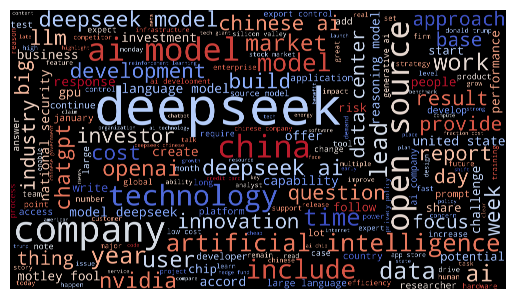

In [148]:
deepseek_wordcloud = WordCloud(
    scale=6, 
    background_color='black',  
    max_words=200,  
    width=1920, 
    colormap='coolwarm',  
    height=1080,
    max_font_size=200,  
    random_state=50
).generate(word_space)

plt.imshow(deepseek_wordcloud)
plt.axis('off')
plt.show()


In [164]:
# or if we want a more fancy wordcloud, corresponding to the DeepSeek logo

img_deepseek = imread('../images.png')
img_ar = np.array(Image.open('../images.png'))


deepseek_wordcloud_logo= WordCloud(
    scale=6, 
    background_color='white',  
    max_words=500,  
    width=1920, 
    mask=img_deepseek,  
    height=1080,
    max_font_size=30, 
    random_state=50
).generate(word_space)



/var/folders/sl/dmcfd6sn2xz848jw02554ty40000gn/T/ipykernel_42993/145285949.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_deepseek = imread('../images.png')


In [165]:
image_colors = ImageColorGenerator(img_deepseek)
deepseek_wordcloud_logo.recolor(color_func=image_colors)

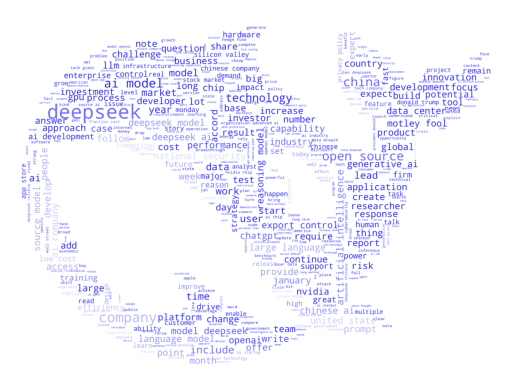

In [166]:
plt.imshow(deepseek_wordcloud_logo)
plt.axis('off')
plt.show()


In [167]:
deepseek_wordcloud.to_file('../word_cloud.jpg')
deepseek_wordcloud_logo.to_file('../word_cloud_logo.jpg')

In [169]:
# LDA modeling

# preprocess the text for LDA, almost the same as the previous preprocessing function, but return a list of tokens
def preprocess_for_lda(text):
    if not isinstance(text, str) or text.strip() == '':
        return []
    
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http[s]?://\S+', '', text)

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    return tokens  



In [170]:
ds_corpus_df['tokens'] = ds_corpus_df['preprocessed_content'].apply(preprocess_for_lda)


# create a dictionary and a corpus for LDA
dictionary = corpora.Dictionary(ds_corpus_df['tokens'])

# purpose of this step below : filter out words with extreme frequencies, to make the modeling more robust.
# We didn't do this before, which led to a lot of repetition in the keywords of each topic.
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=1000) 


# now we transform the tokens into a bow format
corpus = [dictionary.doc2bow(text) for text in ds_corpus_df['tokens']]

# calculate the tfidf weights
tfidf = TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]  

# TRAIN
num_topics = 5
lda_model_tfidf = LdaModel(
    corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto', eta='auto'
)


for idx, topic in lda_model_tfidf.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx+1}: {topic}")


Topic 1: 0.001*"ban" + 0.001*"alibaba" + 0.001*"chatbot" + 0.001*"taiwan" + 0.001*"government" + 0.001*"italy" + 0.001*"china" + 0.001*"copy" + 0.001*"security" + 0.001*"subscribe"
Topic 2: 0.001*"cloud" + 0.001*"llm" + 0.001*"source" + 0.001*"stock" + 0.001*"security" + 0.001*"app" + 0.001*"reasoning" + 0.001*"open" + 0.001*"nvidia" + 0.001*"user"
Topic 3: 0.004*"nvidia" + 0.003*"security" + 0.003*"app" + 0.003*"chip" + 0.003*"ban" + 0.003*"government" + 0.003*"china" + 0.003*"market" + 0.003*"openai" + 0.003*"stock"
Topic 4: 0.002*"energy" + 0.001*"app" + 0.001*"center" + 0.001*"nvidia" + 0.001*"openai" + 0.001*"developer" + 0.001*"mini" + 0.001*"ban" + 0.001*"chatgpt" + 0.001*"market"
Topic 5: 0.002*"credit" + 0.001*"good" + 0.001*"security" + 0.001*"government" + 0.001*"app" + 0.001*"account" + 0.001*"platform" + 0.001*"ban" + 0.001*"select" + 0.001*"log"


#### finally we used gpt to summarize the topics


Prompt : 
> *"We are conducting a study on news coverage of China's large language model, DeepSeek. We have used LDA topic modeling and generated five topics. Below are the top keywords for each topic. Based on these keywords, please analyze and summarize the five topics into meaningful categories, providing a brief description of each. Ensure that the summary captures the essence of the themes present in the news articles"*

#### 1. Regulatory and Geopolitical Challenges
- This topic highlights the impact of government regulations and geopolitical tensions on the development and deployment of China's large language models like DeepSeek. Keywords such as "ban," "Taiwan," "government," "Italy," and "security" suggest discussions on restrictions, international relations, and regulatory hurdles.

#### 2. Technological Advancements and Cloud Integration
- This theme revolves around the technical aspects of large language models, particularly in cloud computing and open-source developments. The presence of words like "cloud," "llm," "source," "security," and "nvidia" indicates discussions on AI infrastructure, cloud-based AI services, and security concerns.

#### 3. Market Impact and Competitive Landscape
- This topic focuses on the economic and market implications of DeepSeek and similar AI models. Keywords such as "nvidia," "stock," "market," "chip," "openai," and "government" suggest concerns about the competitive positioning of Chinese AI technologies in the global market, particularly in relation to hardware suppliers like Nvidia.

#### 4. AI Infrastructure and Energy Consumption
- This category captures discussions on the energy demands and data center requirements of large-scale AI models. Keywords like "energy," "center," "nvidia," "developer," and "market" indicate concerns about the sustainability and computational needs of AI systems.

#### 5. Security, Privacy, and Ethical Considerations
- This topic delves into security risks, data privacy, and ethical concerns surrounding large language models. Words like "credit," "security," "government," "account," and "platform" suggest discussions on user data protection, AI ethics, and government oversight in AI applications.